In [ ]:
# import zipfile

# zip_path = '/content/AllSides.zip'
# extract_path = '/content/'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print(f"Extracted to {extract_path}")

In [234]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

In [235]:
# pip install contractions

In [236]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions
import re
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [237]:
def preprocess_text(text):

    text = text.lower()

    text = contractions.fix(text)

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    text = re.sub(r'\S+@\S+', '', text)

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

In [238]:
base_path = "/content/AllSides"
texts = []
labels = []

In [239]:
for label in ['Left', 'Center', 'Right']:
    path = os.path.join(base_path, label)
    for file in os.listdir(path):
        with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
            text = f.read()
            preprocessed_text = preprocess_text(text)
            texts.append(preprocessed_text)
            labels.append(label)

In [240]:
pd.Series(labels).value_counts()

,count
Left,7803
Right,5563
Center,3996


In [241]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=1, stratify=labels)

In [242]:
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2),
    strip_accents='unicode',
    norm='l2',
    sublinear_tf=True
)

In [243]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [244]:
svm = LinearSVC(
    C=1.0,
    loss='hinge',
    max_iter=2000,
    class_weight='balanced',
    dual=False,
    random_state=42
)

In [245]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': ['balanced', None],
    'tol': [1e-4, 1e-5],
}

In [246]:
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='f1_macro',
    verbose=2
)

In [ ]:
grid_search.fit(X_train_tfidf, y_train)

In [248]:
print("\nBest parameters found:", grid_search.best_params_)
print("\nBest cross-validation score:", grid_search.best_score_)

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

print("\nTop 5 parameter combinations:")
print(cv_results[['params', 'mean_test_score', 'std_test_score']].head())


Best parameters found: {'C': 0.1, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'tol': 1e-05}

Best cross-validation score: 0.7757016595727497

Top 5 parameter combinations:
                                               params  mean_test_score  std_test_score
19  {'C': 0.1, 'class_weight': 'balanced', 'loss':...         0.775702        0.006193
18  {'C': 0.1, 'class_weight': 'balanced', 'loss':...         0.775643        0.006261
31  {'C': 1, 'class_weight': None, 'loss': 'square...         0.772719        0.004226
30  {'C': 1, 'class_weight': None, 'loss': 'square...         0.772627        0.004211
27  {'C': 1, 'class_weight': 'balanced', 'loss': '...         0.769208        0.004493


In [249]:
best_svm = LinearSVC(**grid_search.best_params_, random_state=42)
best_svm.fit(X_train_tfidf, y_train)

LinearSVC(C=0.1, class_weight='balanced', random_state=42, tol=1e-05)

In [250]:
y_pred = best_svm.predict(X_test_tfidf)
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_pred))


Test Set Classification Report:
              precision    recall  f1-score   support

      Center       0.86      0.72      0.78       799
        Left       0.79      0.87      0.83      1561
       Right       0.81      0.77      0.79      1113

    accuracy                           0.81      3473
   macro avg       0.82      0.79      0.80      3473
weighted avg       0.81      0.81      0.81      3473



In [251]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

In [252]:
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False],
}


In [253]:
nb_grid = GridSearchCV(
    MultinomialNB(),
    param_grid_nb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

In [254]:
nb_grid.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
                         'fit_prior': [True, False]},
             scoring='accuracy', verbose=2)

In [255]:
print("\nBest parameters found:", nb_grid.best_params_)
print("Best cross-validation score:", nb_grid.best_score_)

# Get detailed CV results
cv_results = pd.DataFrame(nb_grid.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')


Best parameters found: {'alpha': 0.1, 'fit_prior': True}
Best cross-validation score: 0.7042991994561933


In [256]:
print("\nTop 5 parameter combinations:")
print(cv_results[['params', 'mean_test_score', 'std_test_score']].head())


Top 5 parameter combinations:
                               params  mean_test_score  std_test_score
0   {'alpha': 0.1, 'fit_prior': True}         0.704299        0.009935
2   {'alpha': 0.5, 'fit_prior': True}         0.696811        0.012503
4   {'alpha': 1.0, 'fit_prior': True}         0.690404        0.012758
9  {'alpha': 2.0, 'fit_prior': False}         0.689899        0.009717
7  {'alpha': 1.5, 'fit_prior': False}         0.688387        0.009055


In [257]:
nb_model = nb_grid.best_estimator_
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.1)

In [258]:
nb_pred = nb_model.predict(X_test_tfidf)
print("\nClassification Report:")
print(classification_report(y_test, nb_pred))


Classification Report:
              precision    recall  f1-score   support

      Center       0.76      0.59      0.67       799
        Left       0.65      0.91      0.76      1561
       Right       0.89      0.51      0.65      1113

    accuracy                           0.71      3473
   macro avg       0.76      0.67      0.69      3473
weighted avg       0.75      0.71      0.70      3473



In [259]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [260]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [261]:
word_counts = pd.Series(tokenizer.word_counts).sort_values(ascending=False)
print("\nMost common words in vocabulary:", word_counts.head())
print("Vocabulary size:", len(tokenizer.word_index))


Most common words in vocabulary: said         94295
trump        68781
president    48050
would        44874
state        38011
dtype: int64
Vocabulary size: 221082


In [262]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [263]:
lengths = [len(x) for x in X_train_seq]
print(f"\nSequence length statistics:")
print(f"Mean length: {np.mean(lengths):.2f}")
print(f"Median length: {np.median(lengths):.2f}")
print(f"95th percentile length: {np.percentile(lengths, 95):.2f}")


Sequence length statistics:
Mean length: 465.63
Median length: 372.00
95th percentile length: 872.20


In [264]:
max_length = int(np.percentile(lengths, 95))

In [265]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [266]:
label_map = {'Left': 0, 'Center': 1, 'Right': 2}
y_train_num = np.array([label_map[label] for label in y_train])
y_test_num = np.array([label_map[label] for label in y_test])

In [267]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout

In [268]:
embedding_dim = 100
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

400000it [00:15, 25470.33it/s]


In [269]:
embedding_matrix = np.zeros((5000, embedding_dim))
found_words = 0

for word, i in tqdm(tokenizer.word_index.items()):
    if i >= 5000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        found_words += 1

print(f'Found embeddings for {found_words}/{min(len(tokenizer.word_index), 5000)} words.')

100%|██████████| 221082/221082 [00:00<00:00, 1759888.25it/s]

Found embeddings for 4922/5000 words.


In [270]:
cnn_model = Sequential([
    Embedding(5000, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(2),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train_pad, y_train_num, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 184s 463ms/step - accuracy: 0.5011 - loss: 0.9898 - val_accuracy: 0.7264 - val_loss: 0.6357
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 173s 442ms/step - accuracy: 0.7596 - loss: 0.5987 - val_accuracy: 0.7502 - val_loss: 0.6020
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 201s 439ms/step - accuracy: 0.8119 - loss: 0.4835 - val_accuracy: 0.7775 - val_loss: 0.5447
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 171s 438ms/step - accuracy: 0.8655 - loss: 0.3703 - val_accuracy: 0.7696 - val_loss: 0.5576
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 210s 459ms/step - accuracy: 0.9095 - loss: 0.2654 - val_accuracy: 0.7833 - val_loss: 0.5825
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 195s 440ms/step - accuracy: 0.9373 - loss: 0.1882 - val_accuracy: 0.7883 - val_loss: 0.6327
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 205s 448ms/step - accuracy: 0.9629 - loss: 0.1157 - val_accuracy: 0.7747 - val_loss: 0.7527
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 201s 445ms/step - accuracy: 0.9768 -

In [271]:
cnn_pred = np.argmax(cnn_model.predict(X_test_pad), axis=1)

109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step


In [272]:
print("\nCNN Classification Report:")
print(classification_report(y_test_num, cnn_pred))


CNN Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1561
           1       0.83      0.75      0.79       799
           2       0.80      0.75      0.78      1113

    accuracy                           0.79      3473
   macro avg       0.80      0.78      0.79      3473
weighted avg       0.79      0.79      0.79      3473



In [ ]:
# lstm_model = Sequential([
#     Embedding(5000, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=True),
#     LSTM(128, return_sequences=True),
#     LSTM(64),
#     Dense(32, activation='relu'),
#     Dropout(0.2),
#     Dense(3, activation='softmax')
# ])

# lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# lstm_history = lstm_model.fit(X_train_pad, y_train_num, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


418/418 ━━━━━━━━━━━━━━━━━━━━ 1115s 3s/step - accuracy: 0.4875 - loss: 1.0409 - val_accuracy: 0.4751 - val_loss: 1.0431
Epoch 2/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 1172s 3s/step - accuracy: 0.4852 - loss: 1.0377 - val_accuracy: 0.4751 - val_loss: 1.0437
Epoch 3/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 1141s 3s/step - accuracy: 0.4799 - loss: 1.0475 - val_accuracy: 0.4751 - val_loss: 1.0490
Epoch 4/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 1102s 3s/step - accuracy: 0.4824 - loss: 1.0353 - val_accuracy: 0.4751 - val_loss: 1.0382
Epoch 5/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 1215s 3s/step - accuracy: 0.4944 - loss: 1.0195 - val_accuracy: 0.4751 - val_loss: 1.0485
Epoch 6/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 1104s 3s/step - accuracy: 0.4903 - loss: 1.0142 - val_accuracy: 0.4690 - val_loss: 1.0546
Epoch 7/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 1159s 3s/step - accuracy: 0.4892 - loss: 1.0101 - val_accuracy: 0.4710 - val_loss: 1.0783
Epoch 8/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 1100s 3s/step - accuracy: 0.4927 - loss: 1.0073 - val_accurac

In [ ]:
# lstm_pred = np.argmax(lstm_model.predict(X_test_pad), axis=1)

116/116 ━━━━━━━━━━━━━━━━━━━━ 80s 686ms/step


In [ ]:
# print("\nLSTM Classification Report:")
# print(classification_report(y_test_num, lstm_pred))


LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.98      0.65      1796
           1       0.27      0.00      0.01       799
           2       0.14      0.01      0.01      1113

    accuracy                           0.48      3708
   macro avg       0.30      0.33      0.22      3708
weighted avg       0.33      0.48      0.32      3708



In [273]:
svm_pred = np.array([label_map[label] for label in y_pred])
nb_pred_num = np.array([label_map[label] for label in nb_pred])

In [274]:
ensemble_pred = []
for i in range(len(y_test)):
    preds = [cnn_pred[i], svm_pred[i], nb_pred_num[i]]
    unique_vals, counts = np.unique(preds, return_counts=True)
    majority_vote = unique_vals[np.argmax(counts)]
    ensemble_pred.append(majority_vote)

ensemble_pred = np.array(ensemble_pred)

In [275]:
print("\nEnsemble Model Classification Report:")
print(classification_report(y_test_num, ensemble_pred))


Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.82      1561
           1       0.89      0.71      0.79       799
           2       0.87      0.68      0.77      1113

    accuracy                           0.80      3473
   macro avg       0.83      0.77      0.79      3473
weighted avg       0.81      0.80      0.79      3473



In [ ]:
df = pd.read_csv('V2reddit_posts_PoliticalDiscusions_tokenized.csv')

In [ ]:
df.head()

,post_id,title,content,created_utc,num_comments,upvotes,upvote_ratio,author,title_length,content_length,tokenize_title,tokenize_content,all_text
0,1gixvv3,What do you think is going to be a big surpris...,"Like the title states, what do you think is go...",2024-11-03 21:33:46,9,2,1.00,HERKFOOT21,112,462,"[('think', 'VERB'), ('go', 'VERB'), ('big', 'A...","[('like', 'SCONJ'), ('title', 'NOUN'), ('state...",think go big surprise upset election exclude f...
1,1gio43r,The cost of the inability to successful comple...,The United States has a significant chance of ...,2024-11-03 14:30:25,12,3,0.67,the_original_Retro,86,1982,"[('cost', 'NOUN'), ('inability', 'NOUN'), ('su...","[('united', 'PROPN'), ('states', 'PROPN'), ('s...",cost inability successful complete bipartisans...
2,1gin9zc,What Will the Non MAGA GOP do if trump loses?,Will they have to form a new party since Lara ...,2024-11-03 13:50:36,43,14,0.76,ExpensivePiece7560,45,291,"[('non', 'PROPN'), ('maga', 'PROPN'), ('gop', ...","[('form', 'VERB'), ('new', 'ADJ'), ('party', '...",non maga gop trump lose form new party lara tr...
3,1giooyn,What specific features of political systems yo...,While the issue of senate confirmation has got...,2024-11-03 14:57:15,54,10,0.73,Awesomeuser90,94,1277,"[('specific', 'ADJ'), ('feature', 'NOUN'), ('p...","[('issue', 'NOUN'), ('senate', 'PROPN'), ('con...",specific feature political system general disa...
4,1gioe95,Brass tacks time: who wins between Trump vs Ha...,What does your gut feel who will win the presi...,2024-11-03 14:43:32,252,0,0.43,TaylorSwiftian,59,302,"[('brass', 'VERB'), ('tack', 'NOUN'), ('time',...","[('gut', 'NOUN'), ('feel', 'VERB'), ('win', 'V...",brass tack time win trump vs harris gut feel w...


In [ ]:
df["all_text"].isnull().sum()

0

In [ ]:
preprocessed_text = df["all_text"].apply(preprocess_text)

In [ ]:
X_predict_tfidf = tfidf.transform(preprocessed_text)

In [ ]:
X_predict_seq = tokenizer.texts_to_sequences(preprocessed_text)
X_predict_pad = pad_sequences(X_predict_seq, maxlen=max_length, padding='post', truncating='post')

In [ ]:
cnn_pred = np.argmax(cnn_model.predict(X_predict_pad), axis=1)
svm_pred = best_svm.predict(X_predict_tfidf)
nb_pred = nb_model.predict(X_predict_tfidf)

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step


In [ ]:
svm_pred_num = np.array([label_map[label] for label in svm_pred])
nb_pred_num = np.array([label_map[label] for label in nb_pred])

In [ ]:
ensemble_pred = []
for i in range(len(preprocessed_text)):
    predictions = [cnn_pred[i], svm_pred_num[i], nb_pred_num[i]]
    unique_vals, counts = np.unique(predictions, return_counts=True)
    majority_vote = unique_vals[np.argmax(counts)]
    ensemble_pred.append(majority_vote)

In [ ]:
rev_label_map = {v: k for k, v in label_map.items()}
ensemble_pred_labels = [rev_label_map[pred] for pred in ensemble_pred]

In [ ]:
df['predicted_label_cnn'] = [rev_label_map[pred] for pred in cnn_pred]
df['predicted_label_svm'] = svm_pred
df['predicted_label_nb'] = nb_pred
df['predicted_label_ensemble'] = ensemble_pred_labels

In [ ]:
df.to_csv('reddit_posts_with_predictions.csv', index=False)

In [221]:
df.head()

,post_id,title,content,created_utc,num_comments,upvotes,upvote_ratio,author,title_length,content_length,tokenize_title,tokenize_content,all_text,predicted_label_cnn,predicted_label_svm,predicted_label_nb,predicted_label_ensemble
0,1gixvv3,What do you think is going to be a big surpris...,"Like the title states, what do you think is go...",2024-11-03 21:33:46,9,2,1.00,HERKFOOT21,112,462,"[('think', 'VERB'), ('go', 'VERB'), ('big', 'A...","[('like', 'SCONJ'), ('title', 'NOUN'), ('state...",think go big surprise upset election exclude f...,Right,Right,Left,Right
1,1gio43r,The cost of the inability to successful comple...,The United States has a significant chance of ...,2024-11-03 14:30:25,12,3,0.67,the_original_Retro,86,1982,"[('cost', 'NOUN'), ('inability', 'NOUN'), ('su...","[('united', 'PROPN'), ('states', 'PROPN'), ('s...",cost inability successful complete bipartisans...,Right,Left,Left,Left
2,1gin9zc,What Will the Non MAGA GOP do if trump loses?,Will they have to form a new party since Lara ...,2024-11-03 13:50:36,43,14,0.76,ExpensivePiece7560,45,291,"[('non', 'PROPN'), ('maga', 'PROPN'), ('gop', ...","[('form', 'VERB'), ('new', 'ADJ'), ('party', '...",non maga gop trump lose form new party lara tr...,Right,Center,Left,Left
3,1giooyn,What specific features of political systems yo...,While the issue of senate confirmation has got...,2024-11-03 14:57:15,54,10,0.73,Awesomeuser90,94,1277,"[('specific', 'ADJ'), ('feature', 'NOUN'), ('p...","[('issue', 'NOUN'), ('senate', 'PROPN'), ('con...",specific feature political system general disa...,Right,Right,Left,Right
4,1gioe95,Brass tacks time: who wins between Trump vs Ha...,What does your gut feel who will win the presi...,2024-11-03 14:43:32,252,0,0.43,TaylorSwiftian,59,302,"[('brass', 'VERB'), ('tack', 'NOUN'), ('time',...","[('gut', 'NOUN'), ('feel', 'VERB'), ('win', 'V...",brass tack time win trump vs harris gut feel w...,Right,Right,Left,Right


In [223]:
df["predicted_label_ensemble"].value_counts()

,count
predicted_label_ensemble,
Right,591
Left,309
Center,19


<ipython-input-224-64b5bec05c38>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ideology_counts.index, y=ideology_counts.values, palette="Set2")


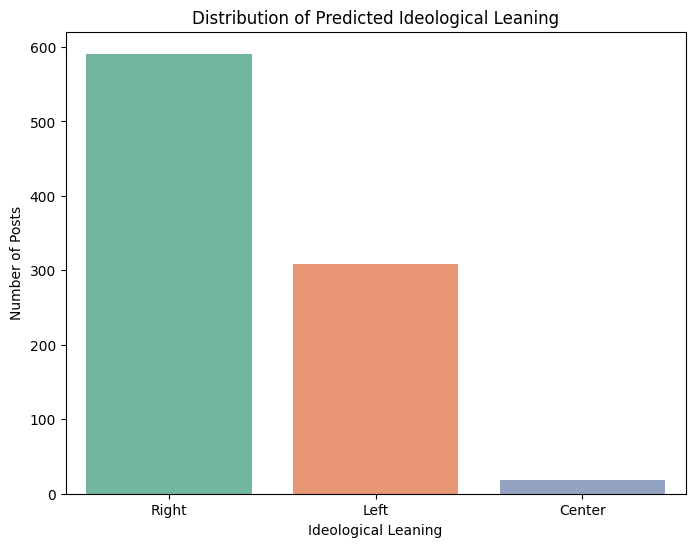

In [224]:
import seaborn as sns

ideology_counts = df["predicted_label_ensemble"].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=ideology_counts.index, y=ideology_counts.values, palette="Set2")
plt.title("Distribution of Predicted Ideological Leaning")
plt.xlabel("Ideological Leaning")
plt.ylabel("Number of Posts")
plt.show()

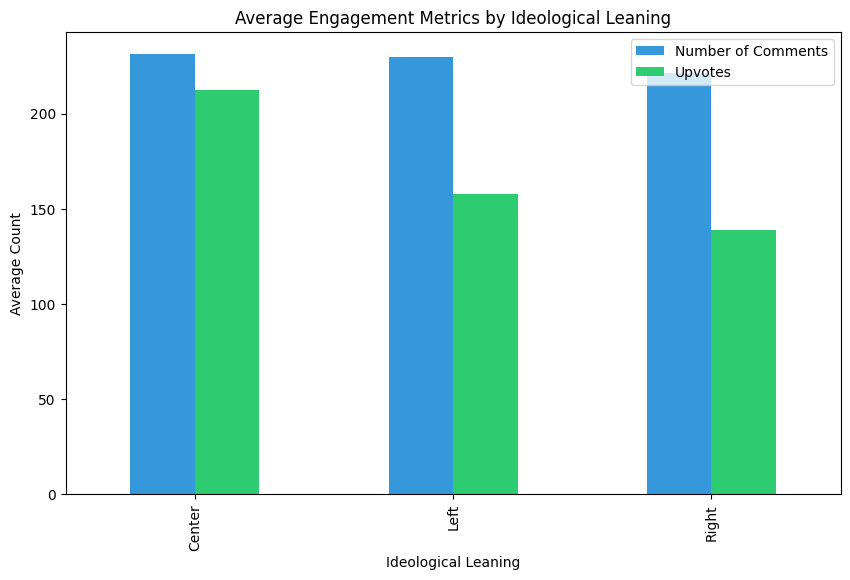

In [226]:
engagement_metrics = df.groupby('predicted_label_ensemble')[['num_comments', 'upvotes']].mean()

engagement_metrics.plot(kind='bar', figsize=(10, 6), color=['#3498db', '#2ecc71'])
plt.title("Average Engagement Metrics by Ideological Leaning")
plt.xlabel("Ideological Leaning")
plt.ylabel("Average Count")
plt.legend(["Number of Comments", "Upvotes"])
plt.show()

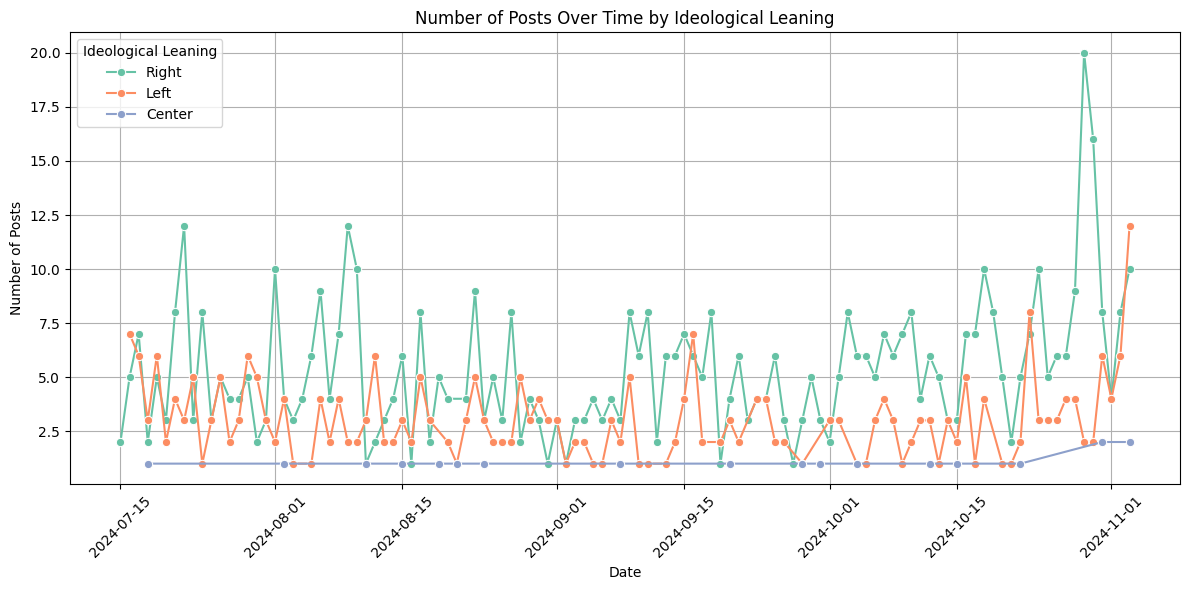

In [231]:
df['created_utc'] = pd.to_datetime(df['created_utc'])

df['date'] = df['created_utc'].dt.date
time_series_data = df.groupby(['date', 'predicted_label_ensemble']).size().reset_index(name='post_count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=time_series_data, x='date', y='post_count', hue='predicted_label_ensemble', marker='o', palette='Set2')
plt.title("Number of Posts Over Time by Ideological Leaning")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.legend(title="Ideological Leaning")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()